In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.optim import  lr_scheduler

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

In [2]:
inception3 = models.inception_v3(weights=True, aux_logits=True) # load pretrained model inception_v3

c:\Users\venna\.conda\envs\intro-to-pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
transform = transforms.Compose([
    transforms.Resize((299, 299)), # inception_v3 expects tensors with a size of N x 3 x 299 x 299
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),  # Randomly rotate the images by 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, etc.
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((299, 299)), # inception_v3 expects tensors with a size of N x 3 x 299 x 299
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = ImageFolder('fruit_and_veg_dataset/train', transform=transform)
test_dataset = ImageFolder('fruit_and_veg_dataset/test', transform=transform)
val_dataset = ImageFolder('fruit_and_veg_dataset/validation', transform=val_transform)

In [6]:
num_classes = len(train_dataset.classes)

In [7]:
# # Get the class to index mapping

# def list_all_samples(dataset):
#     class_names = dataset.classes
#     for i in range(len(dataset)):
#         img, label = dataset[i]
#         img_path = dataset.samples[i][0]  # Get the original file path
#         print(f"Image Path: {img_path}, Label: {class_names[label]}")

# print("Training Dataset:")
# list_all_samples(train_dataset)
# print("\nValidation Dataset:")
# list_all_samples(val_dataset)
# print("\nTest Dataset:")
# list_all_samples(test_dataset)


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [9]:
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader, scheduler=None, lambda_L1 = 0.0):
    training_logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    print(model.aux_logits)
    model.to(device)  # Move the model to the device
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_loss, correct = 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            # Handle the InceptionOutputs for models with aux_logits enabled
            if isinstance(outputs, tuple):
                y_pred, aux_output = outputs
                loss1 = loss_function(y_pred, y)
                loss2 = loss_function(aux_output, y)
                loss = loss1 + 0.4 * loss2  # Combine the losses with a weighting factor for the auxiliary output
            else:
                y_pred = outputs
                loss = loss_function(y_pred, y)

            L1_loss = 0.0
            for p in model.parameters():
                L1_loss = L1_loss + p.abs().sum()
            loss = loss + lambda_L1 * L1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (y_pred.argmax(1) == y).float().sum().item()
        print('-'*80)
        training_logs['train_loss'].append(train_loss / len(train_loader))
        training_logs['train_acc'].append(correct / len(train_loader.dataset))

        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in validation_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)

                if isinstance(outputs, tuple):
                    y_pred, aux_output = outputs
                    loss1 = loss_function(y_pred, y)
                    loss2 = loss_function(aux_output, y)
                    loss = loss1 + 0.4 * loss2
                else:
                    y_pred = outputs
                    loss = loss_function(y_pred, y)

                val_loss += loss.item()
                correct += (y_pred.argmax(1) == y).float().sum().item()
                
        
        training_logs['val_loss'].append(val_loss / len(validation_loader))
        training_logs['val_acc'].append(correct / len(validation_loader.dataset))

        if scheduler:
            scheduler.step()

        print(f"Epochs {epoch + 1}".ljust(10),
              f"train loss: {training_logs['train_loss'][-1]:.5f}",
              f"train acc: {training_logs['train_acc'][-1]:.5f}",

              f"val loss: {training_logs['val_loss'][-1]:.5f}",
              f"val acc: {training_logs['val_acc'][-1]:.5f}",
              )
        #print('-'*80)
    return model, training_logs

In [10]:
num_feature = inception3.fc.in_features
inception3.fc = nn.Linear(num_feature, num_classes)


for param in inception3.parameters():
    param.require_grad = False

# Only the parameters of the final layer should be trainable
for param in inception3.fc.parameters():
    param.requires_grad = True

# Also, make the auxiliary classifier parameters trainable if aux_logits is used
if inception3.aux_logits:
    for param in inception3.AuxLogits.fc.parameters():
        param.requires_grad = True

n_epoch = 50
loss_fn = nn.CrossEntropyLoss()

weight_decay = 0.001
lambda_L1 = 0.0001
learning_rate = 1e-3

optimizer = torch.optim.Adam(inception3.parameters(), lr = learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
net, net_history = train(model=inception3, n_epochs=n_epoch, loss_function=loss_fn, optimizer=optimizer, train_loader=train_dataloader, 
        validation_loader=test_dataloader, scheduler=step_lr_scheduler)

cuda:0
True
cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\venna\.conda\envs\intro-to-pytorch\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

C:\MinGW\ipykernel_28036\4036892942.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


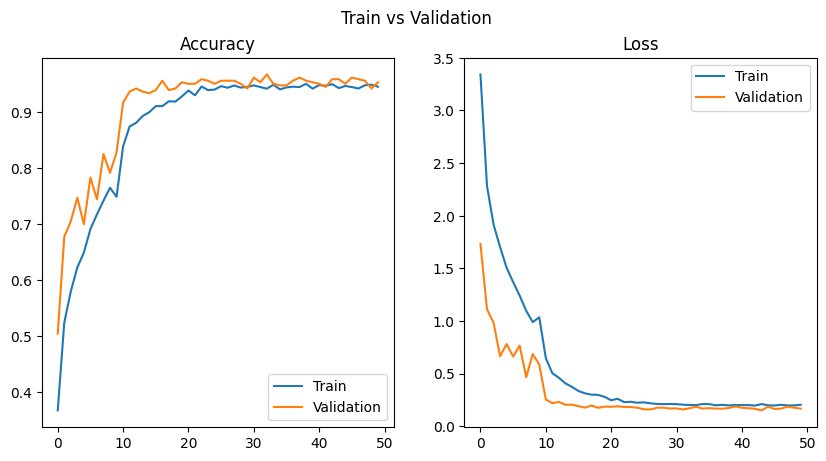

In [ ]:
plot_graph(net_history)

In [ ]:
# save_path = "model/fruit-veg_state_dict"
# torch.save(net.state_dict(), save_path)

In [ ]:
idx_to_class = {v: k for k, v in val_dataloader.dataset.class_to_idx.items()}

In [ ]:
idx_to_class

{0: 'apple',
 1: 'banana',
 2: 'beetroot',
 3: 'bell pepper',
 4: 'cabbage',
 5: 'capsicum',
 6: 'carrot',
 7: 'cauliflower',
 8: 'chilli pepper',
 9: 'corn',
 10: 'cucumber',
 11: 'eggplant',
 12: 'garlic',
 13: 'ginger',
 14: 'grapes',
 15: 'jalepeno',
 16: 'kiwi',
 17: 'lemon',
 18: 'lettuce',
 19: 'mango',
 20: 'onion',
 21: 'orange',
 22: 'paprika',
 23: 'pear',
 24: 'peas',
 25: 'pineapple',
 26: 'pomegranate',
 27: 'potato',
 28: 'raddish',
 29: 'soy beans',
 30: 'spinach',
 31: 'sweetcorn',
 32: 'sweetpotato',
 33: 'tomato',
 34: 'turnip',
 35: 'watermelon'}

In [ ]:
val_dataset.samples[1][0]

'fruit_and_veg_dataset/validation\\apple\\Image_10.jpg'

In [ ]:
# import numpy as np
# import argparse
# import imutils
# import cv2

# # Load the model
# model = inception3
# model.load_state_dict(torch.load('model/fruit-veg_state_dict'))
# # Move the model to the appropriate device (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()  # Set the model to evaluation mode

# idx_to_class = {v: k for k, v in val_dataloader.dataset.class_to_idx.items()}

# # Iterate over the validation data
# for i, (images, labels) in enumerate(val_dataloader):
#     images = images.to(device)
#     labels = labels.to(device)
#     # Get the original file path
#     image_path = val_dataset.samples[i][0]
#     filename = image_path.split('/')[-1]  # Extract the filename from the path

#     # Prepare the original image for display
#     orig = images[0].cpu().permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC and move to CPU
#     orig = (orig * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # De-normalize
#     orig = np.clip(orig * 255.0, 0, 255).astype(np.uint8)
#     orig = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)

#     with torch.no_grad():
#         outputs = model(images)
#         proba = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()  # Softmax to get probabilities
#         predicted_class_idx = np.argmax(proba, axis=1)[0]  # Get the index of the max probability
#         predicted_class = idx_to_class[predicted_class_idx]  # Get the corresponding label
#         confidence = proba[0][predicted_class_idx] * 100  # Get the confidence for the predicted class


#     # Debugging: print model output and calculated probability
#     print(f"Model output (logits): {outputs.cpu().numpy()}")
#     print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}%")

#     # Prepare the label to be displayed
#     label = f"Label: {predicted_class}"
#     prob = f"Confidence: {confidence:.2f}%"

#     # Resize the original image for display
#     output = imutils.resize(orig, width=600)
#     # Put the label and filename on the image
#     cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
#     cv2.putText(output, prob, (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
#     cv2.putText(output, f"File: {filename}", (10, 580), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 100, 0), 1)

#     # Display the image with predictiona
#     cv2.imshow("Output", output)
#     cv2.waitKey(0)  # Wait for key press to show the next image

# cv2.destroyAllWindows()

Model output (logits): [[ 10.3696785 -14.413696   -7.914324   -7.72084   -14.695375   -5.899547
  -12.7836895 -17.069923   -7.6004043 -13.6211815  -9.946879   -8.799133
  -13.583609  -11.907571  -13.038402   -6.8596215  -7.8079143  -8.9627905
  -17.118765   -3.5150344  -3.54183    -2.780279   -8.369801   -5.702693
  -13.405764  -15.964598   -1.1722968  -9.726825   -6.730009  -13.748549
  -20.012018  -12.348657  -12.151069   -2.9390578  -1.2690626  -3.5825057]]
Predicted class: apple, Confidence: 100.00%
Model output (logits): [[ 10.3696785 -14.413696   -7.914324   -7.72084   -14.695375   -5.899547
  -12.7836895 -17.069923   -7.6004043 -13.6211815  -9.946879   -8.799133
  -13.583609  -11.907571  -13.038402   -6.8596215  -7.8079143  -8.9627905
  -17.118765   -3.5150344  -3.54183    -2.780279   -8.369801   -5.702693
  -13.405764  -15.964598   -1.1722968  -9.726825   -6.730009  -13.748549
  -20.012018  -12.348657  -12.151069   -2.9390578  -1.2690626  -3.5825057]]
Predicted class: apple, Co

KeyboardInterrupt: 